# Propensity Score Matching

This notebook implements a comprehensive causal inference framework using **Propensity Score Matching (PSM)** to evaluate the impact of a policy intervention on business outcomes in a discount deal marketplace. The analysis estimates the Average Treatment Effect (ATE) on treated units by creating matched pairs of treated and control observations, ensuring fair comparison between groups that differ in their propensity to receive treatment.

### Research Question
How does a specific policy intervention (treatment assignment) affect business outcomes such as quantity sold and revenue?

### Why Propensity Score Matching?

In observational data, treatment assignment is not random. Deals receiving treatment differ systematically from untreated deals based on observable characteristics (e.g., promotion length, price, discount percentage). This creates **selection bias**—we cannot simply compare treated vs. control means because differences may reflect pre-existing dissimilarities rather than true treatment effects.

**Propensity Score Matching addresses this by:**
- Estimating the probability of treatment based on pre-treatment covariates
- Creating matched pairs of treated and control units with similar propensity scores
- Ensuring balance in covariate distributions between groups
- Enabling causal effect estimation under the Conditional Independence Assumption (CIA)

### Conditional Independence Assumption (CIA)
Treatment assignment is independent of potential outcomes conditional on observed covariates:

$$Y_i(1), Y_i(0) \perp T_i \mid X_i$$

Where:
- $Y_i(1)$: potential outcome if treated
- $Y_i(0)$: potential outcome if not treated
- $T_i$: treatment indicator
- $X_i$: observed covariates


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

### Dataset Overview
- **Total observations:** 710 deals
- **Treatment group:** Deals receiving policy intervention (treatment=1)
- **Control group:** Untreated deals (treatment=0)
- **Time period:** September 2011

### Key Variables

#### Pre-treatment Covariates (X):
| Variable | Description | Type | Range/Notes |
|----------|-------------|------|-------------|
| `min_req` | Minimum purchase requirement | Numeric | Units required |
| `prom_length` | Promotion duration | Numeric | Days |
| `price` | Deal price | Numeric | Currency units |
| `discount_pct` | Discount percentage | Numeric | 0-100% |
| `coupon_duration` | Coupon validity period | Numeric | Days |
| `featured` | Featured promotion flag | Binary | 0/1 |
| `limited_supply` | Limited stock indicator | Binary | 0/1 |
| `fb_likes` | Facebook engagement | Numeric | Count |

#### Outcome Variables (Y):
| Variable | Description | Type |
|----------|-------------|------|
| `quantity_sold` | Units sold | Numeric |
| `revenue` | Total sales revenue | Numeric |

#### Treatment Variable:
| Variable | Description | Value |
|----------|-------------|-------|
| `treatment` | Policy intervention indicator | 1 = treated, 0 = control |


In [2]:
df = pd.read_csv('data/groupon.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 710 entries, 0 to 709
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   deal_id          710 non-null    object
 1   start_date       710 non-null    object
 2   min_req          710 non-null    int64 
 3   treatment        710 non-null    int64 
 4   prom_length      710 non-null    int64 
 5   price            710 non-null    int64 
 6   discount_pct     710 non-null    int64 
 7   coupon_duration  710 non-null    int64 
 8   featured         710 non-null    int64 
 9   limited_supply   710 non-null    int64 
 10  fb_likes         710 non-null    int64 
 11  quantity_sold    710 non-null    int64 
 12  revenue          710 non-null    int64 
dtypes: int64(11), object(2)
memory usage: 72.2+ KB


In [3]:
df.head()

,deal_id,start_date,min_req,treatment,prom_length,price,discount_pct,coupon_duration,featured,limited_supply,fb_likes,quantity_sold,revenue
0,heli-flights,9/23/2011,10,1,4,99,51,185,1,1,290,540,53460
1,gl-champion-series-tennis-electric-factory,9/23/2011,20,1,2,95,41,9,0,1,43,190,18050
2,realm-of-terror-horror-experience,9/23/2011,50,1,3,25,50,38,0,1,208,380,9500
3,newport-gourmet,9/23/2011,15,1,3,50,50,369,0,1,16,90,4500
4,the-clayroom,9/23/2011,20,1,4,25,52,185,0,1,85,580,14500


In [4]:
df.select_dtypes("number").groupby('treatment').mean()

,min_req,prom_length,price,discount_pct,coupon_duration,featured,limited_supply,fb_likes,quantity_sold,revenue
treatment,,,,,,,,,,
0,1.00000,3.809717,37.870445,52.973684,95.941296,0.105263,0.852227,77.941296,333.002024,9720.987854
1,26.50463,3.379630,29.421296,53.263889,131.842593,0.143519,0.777778,113.203704,509.351852,12750.694444


In [5]:
# separate control and treatment for t-test
df_control = df[df.treatment==0]
df_treatment = df[df.treatment==1]

# T-test

In [6]:
# student's t-test for revenue (dependent variable)
from scipy.stats import ttest_ind

print(df_control.revenue.mean(), df_treatment.revenue.mean())

# compare samples
_, p = ttest_ind(df_control.revenue, df_treatment.revenue)
print(f'p={p:.3f}')

# interpret
alpha = 0.05  # significance level
if p > alpha:
    print('same distributions/same group mean (fail to reject H0 - we do not have enough evidence to reject H0)')
else:
    print('different distributions/different group mean (reject H0)')

9720.987854251012 12750.694444444445
p=0.040
different distributions/different group mean (reject H0)


In [7]:
# student's t-test for facebook likes (dependent variable)
from scipy.stats import ttest_ind

print(df_control.fb_likes.mean(), df_treatment.fb_likes.mean())

# compare samples
_, p = ttest_ind(df_control.fb_likes, df_treatment.fb_likes)
print(f'p={p:.3f}')

# interpret
alpha = 0.05  # significance level
if p > alpha:
    print('same distributions/same group mean (fail to reject H0 - we do not have enough evidence to reject H0)')
else:
    print('different distributions/different group mean (reject H0)')

77.9412955465587 113.20370370370371
p=0.004
different distributions/different group mean (reject H0)


# Logistic Regression Model

The propensity score is estimated using **logistic regression**, modeling the probability of treatment given observed covariates:

$$\text{Propensity Score} = P(T_i = 1 \mid X_i) = \frac{1}{1 + e^{-(\beta_0 + X_i\beta)}}$$

### Logistic Model Specification

```
Treatment ~ prom_length + price + discount_pct + coupon_duration + featured + limited_supply
```

In [8]:
# choose features for propensity score calculation
X = df[['prom_length', 'price', 'discount_pct', 'coupon_duration', 'featured', 'limited_supply']]
y = df['treatment']

X.head()

,prom_length,price,discount_pct,coupon_duration,featured,limited_supply
0,4,99,51,185,1,1
1,2,95,41,9,0,1
2,3,25,50,38,0,1
3,3,50,50,369,0,1
4,4,25,52,185,0,1


In [9]:
# use logistic regression to calculate the propensity scores
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X, y)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [13]:
coeffs = pd.DataFrame({
    'column':X.columns.to_numpy(),
    'coeff':lr.coef_.ravel(),
})
coeffs

,column,coeff
0,prom_length,-0.328385
1,price,-0.008594
2,discount_pct,-0.007937
3,coupon_duration,0.003520
4,featured,0.307756
5,limited_supply,-0.366596


In [14]:
# prediction
pred_binary = lr.predict(X)  # binary 0 control, 1, treatment
pred_prob = lr.predict_proba(X)  # probabilities for classes

print('the binary prediction is:', pred_binary[0])
print('the corresponding probabilities are:', pred_prob[0])

the binary prediction is: 0
the corresponding probabilities are: [0.74082122 0.25917878]



### Propensity Score Calculation

For each observation $i$, the propensity score is:

$$PS_i = \frac{e^{\beta_0 + \sum_j \beta_j X_{ij}}}{1 + e^{\beta_0 + \sum_j \beta_j X_{ij}}}$$

Two representations are computed:
1. **Propensity Score:** Raw probability, range [0, 1]
2. **Propensity Score (Logit):** Log-odds transformation, range $(-\infty, +\infty)$

$$\text{Logit}(PS) = \log\left(\frac{PS}{1-PS}\right)$$

In [15]:
# the propensity score (ps) is the probability of being 1 (i.e., in the treatment group)
df['ps'] = pred_prob[:, 1]

# calculate the logit of the propensity score for matching if needed
def logit(p):
    logit_value = math.log(p / (1 - p))
    return logit_value

df['ps_logit'] = df.ps.apply(lambda x: logit(x))

df.head()


,deal_id,start_date,min_req,treatment,prom_length,price,discount_pct,coupon_duration,featured,limited_supply,fb_likes,quantity_sold,revenue,ps,ps_logit
0,heli-flights,9/23/2011,10,1,4,99,51,185,1,1,290,540,53460,0.259179,-1.050241
1,gl-champion-series-tennis-electric-factory,9/23/2011,20,1,2,95,41,9,0,1,43,190,18050,0.230236,-1.206977
2,realm-of-terror-horror-experience,9/23/2011,50,1,3,25,50,38,0,1,208,380,9500,0.288411,-0.903115
3,newport-gourmet,9/23/2011,15,1,3,50,50,369,0,1,16,90,4500,0.511772,0.047096
4,the-clayroom,9/23/2011,20,1,4,25,52,185,0,1,85,580,14500,0.325204,-0.729956


<Axes: xlabel='ps', ylabel='Count'>

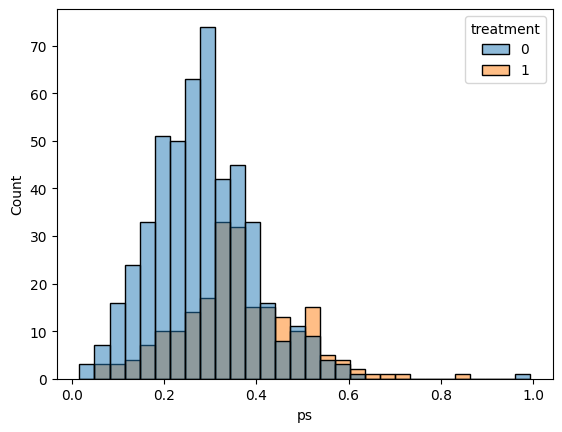

In [16]:
# check the overlap of ps for control and treatment using histogram
# if not much overlap, the matching won't work
sns.histplot(data=df, x='ps', hue='treatment')  # multiple="dodge" for 

<Axes: xlabel='ps1', ylabel='Count'>

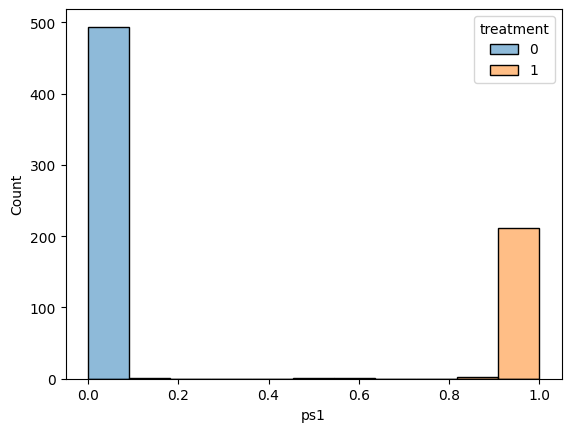

In [17]:
# adding 'min_req' here makes matching not working - because treatment is derived from min_req
# there is no overlap and thus matching will not work
X1 = df[['min_req', 'prom_length', 'price', 'discount_pct', 'coupon_duration', 'featured','limited_supply']]
y = df['treatment']

# use logistic regression to calculate the propensity scores
lr1 = LogisticRegression(max_iter=1000)
lr1.fit(X1, y)

pred_prob1 = lr1.predict_proba(X1)  # probabilities for classes
df['ps1'] = pred_prob1[:, 1]

sns.histplot(data=df, x='ps1', hue='treatment')

<Axes: xlabel='start_date', ylabel='revenue'>

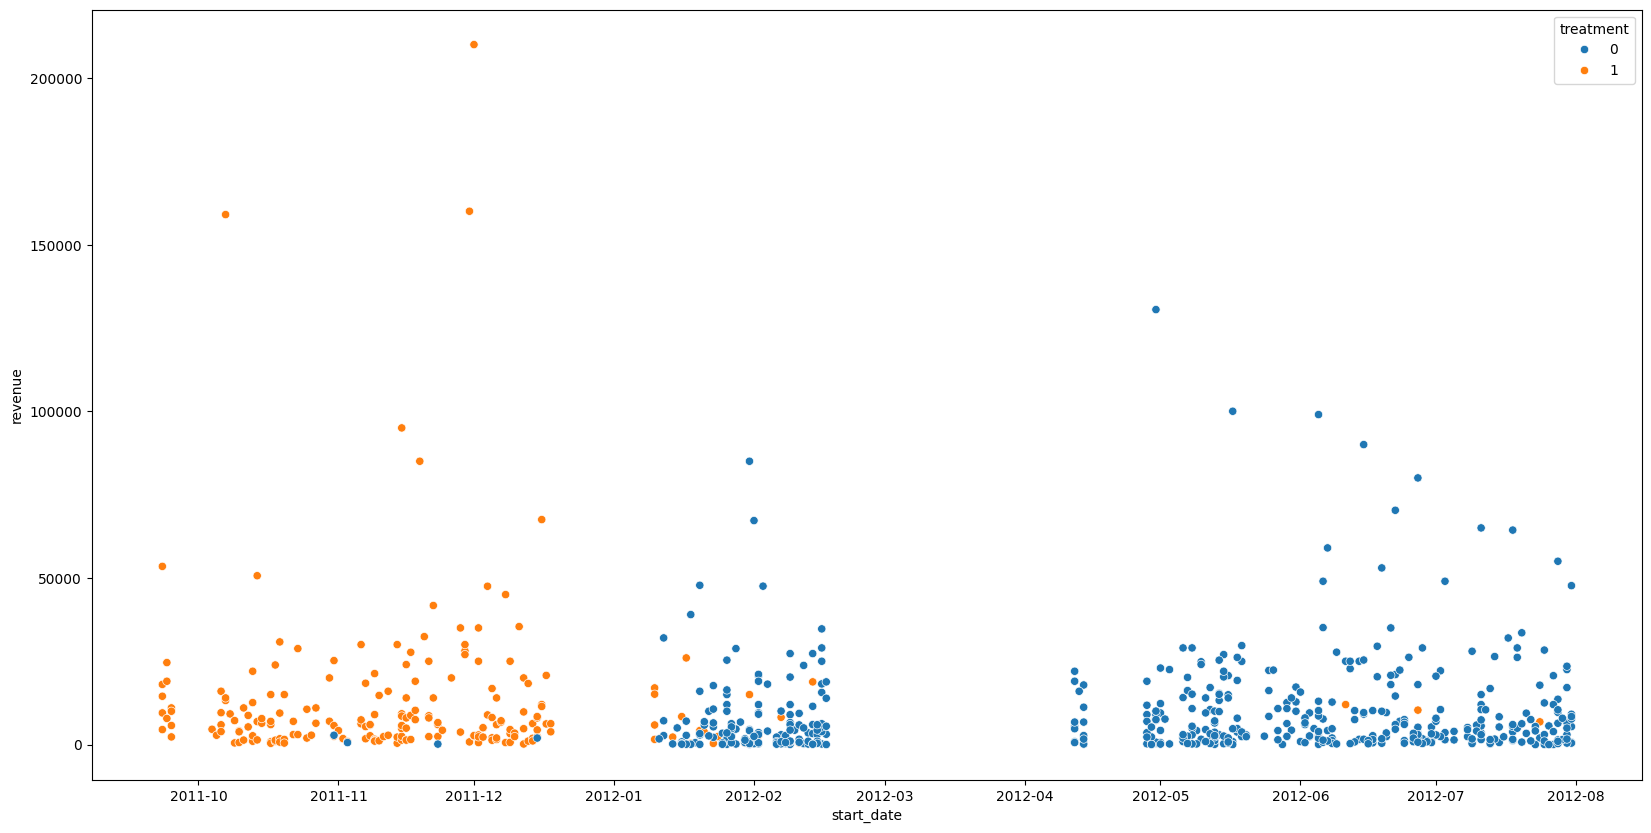

In [19]:
# stating date can also determine treatment value for most cases
# so we do not include it in the propensity score calculation
df.start_date = pd.to_datetime(df.start_date)
fig, ax = plt.subplots(figsize=(20, 10))
sns.scatterplot(data=df, x='start_date', y='revenue', hue='treatment')

<Axes: xlabel='ps2', ylabel='Count'>

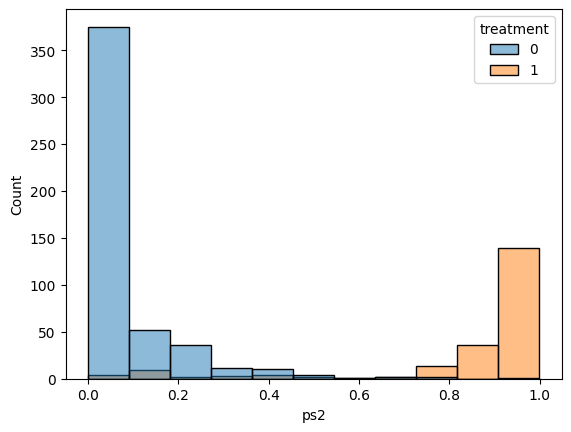

In [20]:
# adding 'starting_date' here via a `recency` feature
# there is only little overlap resulting in not enough matched observations

last_date = df.start_date.max()
df['recency'] = (last_date - df.start_date).dt.days

X2 = df[['recency', 'prom_length', 'price', 'discount_pct', 'coupon_duration', 'featured','limited_supply']]
y = df['treatment']

# use logistic regression to calculate the propensity scores
lr2 = LogisticRegression(max_iter=1000)
lr2.fit(X2, y)

pred_prob2 = lr2.predict_proba(X2)  # probabilities for classes
df['ps2'] = pred_prob2[:, 1]

sns.histplot(data=df, x='ps2', hue='treatment')

## 5. Nearest Neighbor Matching Algorithm

### Matching Procedure

Nearest neighbor matching with caliper control is implemented using **KNeighborsRegressor** with radius constraint:

$$\text{Caliper} = 0.25 \times \text{SD}(\text{Propensity Score})$$

The caliper ensures only matches within a reasonable distance are accepted, preventing poor-quality matches.

### Algorithm Steps

1. **For each treated unit** $i$ with propensity score $PS_i$:
   - Calculate distances to all control units: $d_{ij} = |PS_i - PS_j|$
   - Identify controls within caliper: $d_{ij} < \text{caliper}$
   - Select the control with **minimum distance** (nearest neighbor)
   - Flag the match pair $(i, j)$

2. **Matching without replacement:** Each control unit matched to at most one treated unit

3. **Quality assurance:** Discard matches exceeding the caliper threshold

In [23]:
# use 25% of standard deviation of the propensity score as the caliper/radius
# get the k closest neighbors for each observations
# relax caliper and increase k can provide more matches

from sklearn.neighbors import NearestNeighbors

caliper = np.std(df.ps) * 0.25
print(f'caliper (radius) is: {caliper:.4f}')

n_neighbors = 10

# setup knn
knn = NearestNeighbors(n_neighbors=n_neighbors, radius=caliper)

ps = df[['ps']]  # double brackets as a dataframe
knn.fit(ps)

caliper (radius) is: 0.0304


,n_neighbors,10
,radius,np.float64(0....7389415794064)
,algorithm,'auto'
,leaf_size,30
,metric,'minkowski'
,p,2
,metric_params,None
,n_jobs,None


In [24]:
# distances and indexes
distances, neighbor_indexes = knn.kneighbors(ps)

print(neighbor_indexes.shape)

# the 10 closest points to the first point
print(distances[0])
print(neighbor_indexes[0])

(710, 10)
[0.00000000e+00 7.98291044e-05 3.78151327e-04 7.53417947e-04
 1.18942307e-03 1.37593667e-03 1.37593667e-03 1.62490584e-03
 1.67879573e-03 2.01191620e-03]
[  0 348 388 415 624 494 150 463 372 345]


In [25]:
# for each point in treatment, we find a matching point in control without replacement
# note the 10 neighbors may include both points in treatment and control

matched_control = []  # keep track of the matched observations in control

for current_index, row in df.iterrows():  # iterate over the dataframe
    if row.treatment == 0:  # the current row is in the control group
        df.loc[current_index, 'matched'] = np.nan  # set matched to nan
    else: 
        for idx in neighbor_indexes[current_index, :]: # for each row in treatment, find the k neighbors
            # make sure the current row is not the idx - don't match to itself
            # and the neighbor is in the control 
            if (current_index != idx) and (df.loc[idx].treatment == 0):
                if idx not in matched_control:  # this control has not been matched yet
                    df.loc[current_index, 'matched'] = idx  # record the matching
                    matched_control.append(idx)  # add the matched to the list
                    break

In [26]:
# try to increase the number of neighbors and/or caliper to get more matches
print('total observations in treatment:', len(df[df.treatment==1]))
print('total matched observations in control:', len(matched_control))

total observations in treatment: 216
total matched observations in control: 184


In [27]:
# control have no match
treatment_matched = df.dropna(subset=['matched'])  # drop not matched

# matched control observation indexes
control_matched_idx = treatment_matched.matched
control_matched_idx = control_matched_idx.astype(int)  # change to int
control_matched = df.loc[control_matched_idx, :]  # select matched control observations

# combine the matched treatment and control
df_matched = pd.concat([treatment_matched, control_matched])

df_matched.treatment.value_counts()

treatment
1    184
0    184
Name: count, dtype: int64

In [28]:
# matched control and treatment
df_matched_control = df_matched[df_matched.treatment==0]
df_matched_treatment = df_matched[df_matched.treatment==1]

In [29]:
# student's t-test for revenue (dependent variable) after matching
# p value is not significant now
from scipy.stats import ttest_ind
print(df_matched_control.revenue.mean(), df_matched_treatment.revenue.mean())

# compare samples
_, p = ttest_ind(df_matched_control.revenue, df_matched_treatment.revenue)
print(f'p={p:.3f}')

# interpret
alpha = 0.05  # significance level
if p > alpha:
    print('same distributions/same group mean (fail to reject H0 - we do not have enough evidence to reject H0)')
else:
    print('different distributions/different group mean (reject H0)')

8697.255434782608 13304.076086956522
p=0.026
different distributions/different group mean (reject H0)


In [30]:
# student's t-test for facebook likes(dependent variable) after matching
# p value is smaller compared with before matching
from scipy.stats import ttest_ind
print(df_matched_control.fb_likes.mean(), df_matched_treatment.fb_likes.mean())

# compare samples
_, p = ttest_ind(df_matched_control.fb_likes, df_matched_treatment.fb_likes)
print(f'p={p:.3f}')

# interpret
alpha = 0.05  # significance level
if p > alpha:
    print('same distributions/same group mean (fail to reject H0 - we do not have enough evidence to reject H0)')
else:
    print('different distributions/different group mean (reject H0)')

67.27173913043478 116.07608695652173
p=0.001
different distributions/different group mean (reject H0)


In [31]:
# As an effect size, Cohen's d is typically used to represent the magnitude of differences between two (or more) groups on a given variable, with larger values representing a greater differentiation between the two groups on that variable.
# we hope the effect sizes for features decrease after matching
# adapted from https://machinelearningmastery.com/effect-size-measures-in-python/

from numpy import mean
from numpy import var
from math import sqrt
 
# function to calculate Cohen's d for independent samples
def cohen_d(d1, d2):
	# calculate the size of samples
	n1, n2 = len(d1), len(d2)
	# calculate the variance of the samples
	s1, s2 = var(d1, ddof=1), var(d2, ddof=1)
	# calculate the pooled standard deviation
	s = sqrt(((n1 - 1) * s1 + (n2 - 1) * s2) / (n1 + n2 - 2))
	# calculate the means of the samples
	u1, u2 = mean(d1), mean(d2)
	# calculate the effect size
	return (u1 - u2) / s

In [32]:
effect_sizes = []
cols = ['prom_length', 'price', 'discount_pct', 'coupon_duration', 'featured','limited_supply']

for cl in cols:
    _, p_before = ttest_ind(df_control[cl], df_treatment[cl])
    _, p_after = ttest_ind(df_matched_control[cl], df_matched_treatment[cl])
    cohen_d_before = cohen_d(df_treatment[cl], df_control[cl])
    cohen_d_after = cohen_d(df_matched_treatment[cl], df_matched_control[cl])
    effect_sizes.append([cl,'before', cohen_d_before, p_before])
    effect_sizes.append([cl,'after', cohen_d_after, p_after])

In [33]:
df_effect_sizes = pd.DataFrame(effect_sizes, columns=['feature', 'matching', 'effect_size', 'p-value'])
df_effect_sizes

,feature,matching,effect_size,p-value
0,prom_length,before,-0.328313,0.000063
1,prom_length,after,-0.047032,0.652172
2,price,before,-0.233573,0.004315
3,price,after,0.010972,0.916242
4,discount_pct,before,0.035411,0.664344
5,discount_pct,after,0.117354,0.261063
6,coupon_duration,before,0.282300,0.000571
7,coupon_duration,after,-0.015018,0.885543
8,featured,before,0.119074,0.144802
9,featured,after,-0.061299,0.556925


<Axes: xlabel='effect_size', ylabel='feature'>

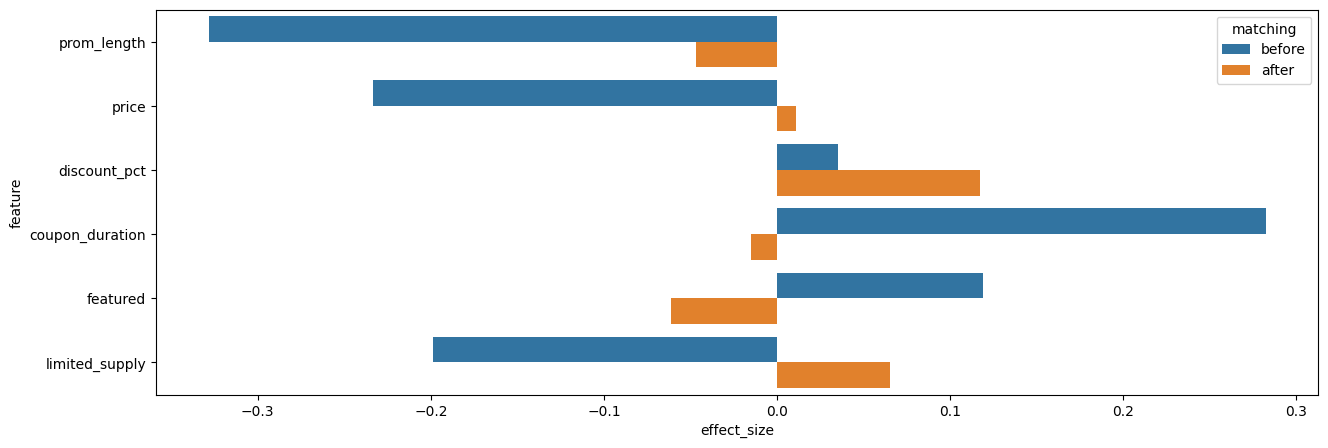

In [34]:
# discount_pct and featured are not significant, all other features are more balanced after matching
fig, ax = plt.subplots(figsize=(15, 5))
sns.barplot(data=df_effect_sizes, x='effect_size', y='feature', hue='matching', orient='h')

In [35]:
# !pip install psmpy

In [36]:
from psmpy import PsmPy
from psmpy.plotting import *

In [37]:
df_psmpy = pd.read_csv('data/groupon.csv')
df_psmpy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 710 entries, 0 to 709
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   deal_id          710 non-null    object
 1   start_date       710 non-null    object
 2   min_req          710 non-null    int64 
 3   treatment        710 non-null    int64 
 4   prom_length      710 non-null    int64 
 5   price            710 non-null    int64 
 6   discount_pct     710 non-null    int64 
 7   coupon_duration  710 non-null    int64 
 8   featured         710 non-null    int64 
 9   limited_supply   710 non-null    int64 
 10  fb_likes         710 non-null    int64 
 11  quantity_sold    710 non-null    int64 
 12  revenue          710 non-null    int64 
dtypes: int64(11), object(2)
memory usage: 72.2+ KB


In [38]:
# exclude: ignore any covariates (columns) passed to the it during model fitting
# indx - required parameter that references a unique ID number for each case
psm = PsmPy(df_psmpy, treatment='treatment', indx='deal_id', exclude = ['min_req', 'start_date', 'fb_likes', 'quantity_sold', 'revenue'])

In [39]:
# same as my code using balance=False
psm.logistic_ps(balance=False)
psm.predicted_data

,deal_id,prom_length,price,discount_pct,coupon_duration,featured,limited_supply,propensity_score,propensity_logit,treatment
0,3rd-coast-cruising-1,3,75,50,378,1,1,0.541488,0.166333,0
1,516-skydive-new-york,7,145,39,170,0,1,0.063623,-2.689036,0
2,92nd-st-y-nyc,3,29,82,125,0,0,0.392219,-0.437994,0
3,above-all-cruises-ny,4,39,51,207,0,1,0.317265,-0.766371,0
4,adaptive-adventures,3,10,0,5,0,1,0.321258,-0.747996,0
...,...,...,...,...,...,...,...,...,...,...
705,gl-windy-city-circus-1,4,20,50,5,0,1,0.212691,-1.308780,1
706,lets-go-paragliding,6,99,58,73,0,1,0.083981,-2.389441,1
707,spare-time-chicago-3,4,12,74,166,0,0,0.392404,-0.437220,1
708,dc-gmt-slice-chicago-tours,7,22,51,106,0,1,0.128638,-1.913052,1


In [40]:
psm.kdtree_matched(matcher='propensity_logit', replacement=False, caliper=None)

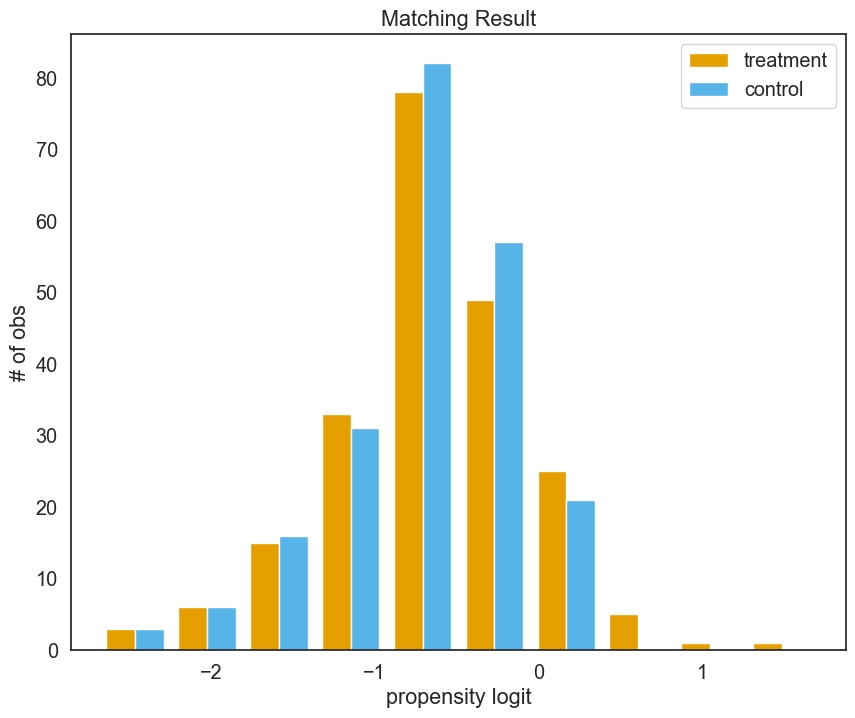

In [41]:
psm.plot_match(Title='Matching Result', Ylabel='# of obs', Xlabel= 'propensity logit', names = ['treatment', 'control'])

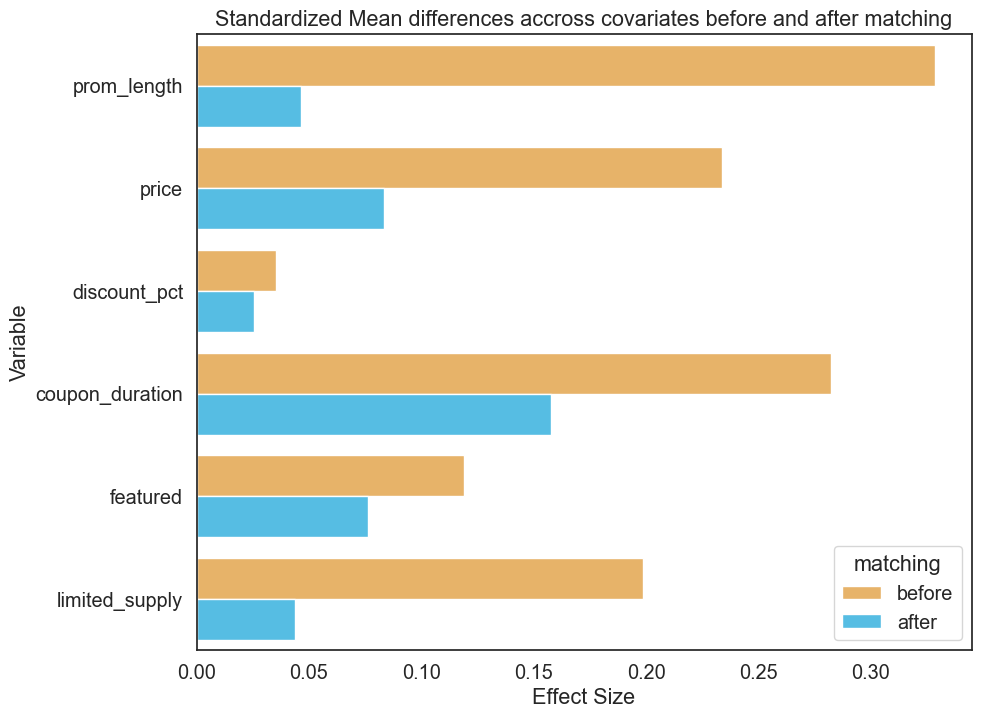

In [42]:
psm.effect_size_plot()

In [43]:
psm.effect_size

,Variable,matching,Effect Size
0,prom_length,before,0.328313
1,prom_length,after,0.046409
2,price,before,0.233573
3,price,after,0.083221
4,discount_pct,before,0.035411
5,discount_pct,after,0.025735
6,coupon_duration,before,0.282300
7,coupon_duration,after,0.157812
8,featured,before,0.119074
9,featured,after,0.076153
